## Artículo
https://medium.com/@mrconnor/harnessing-deep-reinforcement-learning-for-algorithmic-trading-b4c67534b33a

In [1]:

#!pip install yfinance
#!pip install ta
#!pip install stable.baselines3
#!pip3 install torch torchvision torchaudio

#!pip install TA-Lib
import warnings
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import ta
import os
#import talib
warnings.filterwarnings("ignore")
# Optional Plotly Method Imports
import plotly
import cufflinks as cf
cf.go_offline()


from stable_baselines3 import A2C, PPO, DDPG
from stable_baselines3.common.policies import ActorCriticPolicy #MlpPolicy for A2C and PPO
from stable_baselines3.td3.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import ActionNoise, OrnsteinUhlenbeckActionNoise

import seeding
import gymnasium as gym
#from gym import spaces

sns.set_style('whitegrid')
%matplotlib inline


## Recopilación de datos

In [2]:
#DJIA acciones 
tic = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX',  
      'CSCO', 'KO', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC',  
      'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM',  
      'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIS' ]

In [3]:
stock_data = pd.DataFrame() 
stock_start_date = '2009-01-01'
stock_end_date   = '2021-07-01' 

for s in tic: 

  temp_data = yfinance.download(s,
                                start=stock_start_date,
                                end=stock_end_date) 
  temp_data['Ticker'] = s 
  stock_data = pd.concat([stock_data, temp_data])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## Exploración de datos

In [4]:
stock_data.head()

Open       High        Low      Close  Adj Close   Volume   
Date                                                                         
2009-01-02  57.549999  59.389999  57.520000  59.189999  38.520367  5313900  \
2009-01-05  58.790001  59.090000  58.110001  58.500000  38.071320  3768800   
2009-01-06  58.740002  59.810001  58.610001  59.189999  38.520367  4966200   
2009-01-07  58.610001  58.959999  57.580002  58.070000  37.791485  4598100   
2009-01-08  57.680000  58.709999  57.450001  58.580002  38.123379  3944900   

           Ticker  
Date               
2009-01-02    MMM  
2009-01-05    MMM  
2009-01-06    MMM  
2009-01-07    MMM  
2009-01-08    MMM

In [5]:
stock_data.Ticker.unique()

array(['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO',
       'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD',
       'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA',
       'WMT', 'DIS'], dtype=object)

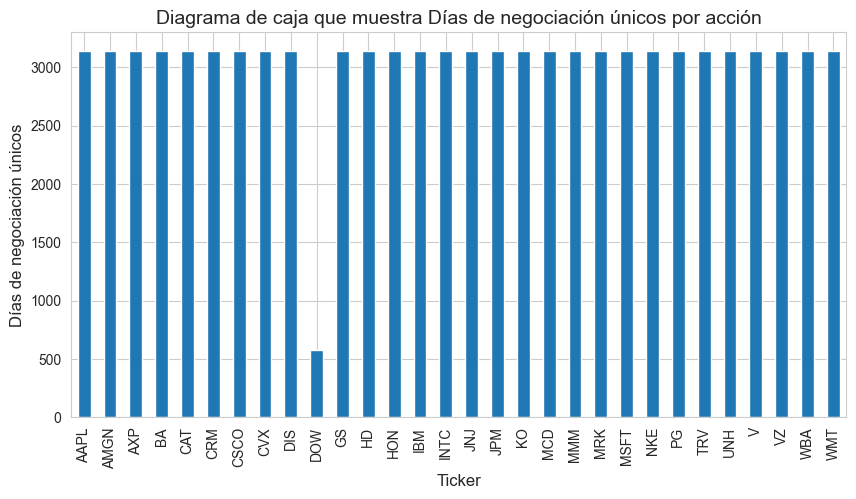

In [6]:
plt.figure(figsize=(10, 5)) 
stock_data.groupby(by='Ticker').count()['Open'].plot(kind='bar') 
plt.xlabel('Ticker', fontsize = 12) 
plt.ylabel('Días de negociación únicos', fontsize=12) 
plt.title('Diagrama de caja que muestra Días de negociación únicos por acción', fontsize= 14) 
plt.show()

## EDA

In [7]:
#EDA
df=stock_data.copy()
# Dropping Closing Price Column
df=df.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis=1)
#Remanimg Adj Close
df=df.rename(columns={'Adj Close': 'AdjClose'})
df=df.sort_values(by= ['Date', 'Ticker'])
df=df.reset_index()
df

Date    AdjClose Ticker
0     2009-01-02    2.754724   AAPL
1     2009-01-02   43.422920   AMGN
2     2009-01-02   15.308591    AXP
3     2009-01-02   33.941101     BA
4     2009-01-02   31.408834    CAT
...          ...         ...    ...
91776 2021-06-30  391.318970    UNH
91777 2021-06-30  230.439896      V
91778 2021-06-30   50.279766     VZ
91779 2021-06-30   47.943348    WBA
91780 2021-06-30  136.692169    WMT

[91781 rows x 3 columns]

In [8]:
df=df.pivot(index= 'Date', columns= 'Ticker')
df=df.droplevel(0, axis=1)
df=df.fillna(0)
df

Ticker            AAPL        AMGN         AXP          BA         CAT   
Date                                                                     
2009-01-02    2.754724   43.422920   15.308591   33.941101   31.408834  \
2009-01-05    2.870985   43.908752   15.799605   34.631153   30.853113   
2009-01-06    2.823631   42.944454   16.686609   34.736176   30.665623   
2009-01-07    2.762617   42.841400   15.983674   33.573547   29.239468   
2009-01-08    2.813917   43.621670   16.007639   33.596058   29.473820   
...                ...         ...         ...         ...         ...   
2021-06-24  131.864746  225.713898  164.034973  250.570007  209.842819   
2021-06-25  131.568207  227.334488  165.244217  248.380005  206.944031   
2021-06-28  133.218887  227.484375  160.690140  239.960007  206.905746   
2021-06-29  134.750885  227.128433  160.173309  235.759995  205.786438   
2021-06-30  135.373611  228.336853  161.128983  239.559998  208.206863   

Ticker             CRM       CSCO        CVX         DIS        DOW  ...   
Date                                                                 ...   
2009-01-02    8.505000  11.859256  43.253635   20.597498   0.000000  ...  \
2009-01-05    8.337500  11.964145  43.332756   20.235834   0.000000  ...   
2009-01-06    8.650000  12.439631  43.722805   20.933325   0.000000  ...   
2009-01-07    8.000000  12.110985  41.806564   19.960281   0.000000  ...   
2009-01-08    8.227500  12.264817  41.964836   19.719177   0.000000  ...   
...                ...        ...        ...         ...        ...  ...   
2021-06-24  243.770004  49.704929  99.019653  177.929993  57.176197  ...   
2021-06-25  241.869995  49.968616  99.167526  178.350006  57.339275  ...   
2021-06-28  244.570007  49.874443  96.108406  176.570007  56.985943  ...   
2021-06-29  245.809998  49.827351  95.895828  173.929993  57.058426  ...   
2021-06-30  244.270004  49.912109  96.801552  175.770004  57.330219  ...   

Ticker            MRK        MSFT         NKE          PG         TRV   
Date                                                                    
2009-01-02  17.823139   15.129078   11.076158   40.760227   31.863060  \
2009-01-05  17.552919   15.270471   11.155478   40.468143   31.390751   
2009-01-06  17.230949   15.449069   10.930029   40.351322   30.432034   
2009-01-07  16.954979   14.518853   10.533413   39.643856   29.226599   
2009-01-08  16.880236   14.972803   10.727547   39.208992   29.769409   
...               ...         ...         ...         ...         ...   
2021-06-24  72.134079  261.997437  130.919876  126.599785  144.417374   
2021-06-25  72.927597  260.356812  151.253586  128.408081  146.102585   
2021-06-28  72.606415  263.991730  149.303528  128.788788  143.916641   
2021-06-29  72.937035  266.624573  152.821503  127.913177  143.984055   
2021-06-30  73.466042  266.133362  151.390778  128.417587  144.167023   

Ticker             UNH           V         VZ        WBA         WMT  
Date                                                                  
2009-01-02   22.622524   12.055779  15.976200  17.254658   41.292149  
2009-01-05   22.253546   12.141509  14.979990  18.125835   40.815533  
2009-01-06   21.728777   12.996510  14.740160  18.038046   40.454460  
2009-01-07   21.564781   12.714517  14.927338  18.254145   40.107830  
2009-01-08   21.900963   12.579160  15.156630  18.125835   37.103725  
...                ...         ...        ...        ...         ...  
2021-06-24  389.784729  232.824936  50.584873  47.478592  132.708313  
2021-06-25  395.726227  233.889297  50.593845  47.533268  134.278610  
2021-06-28  392.315674  230.705978  50.414371  47.578835  133.861801  
2021-06-29  389.032257  232.539093  50.109268  47.378345  133.086334  
2021-06-30  391.318970  230.439896  50.279766  47.943348  136.692169  

[3145 rows x 30 columns]

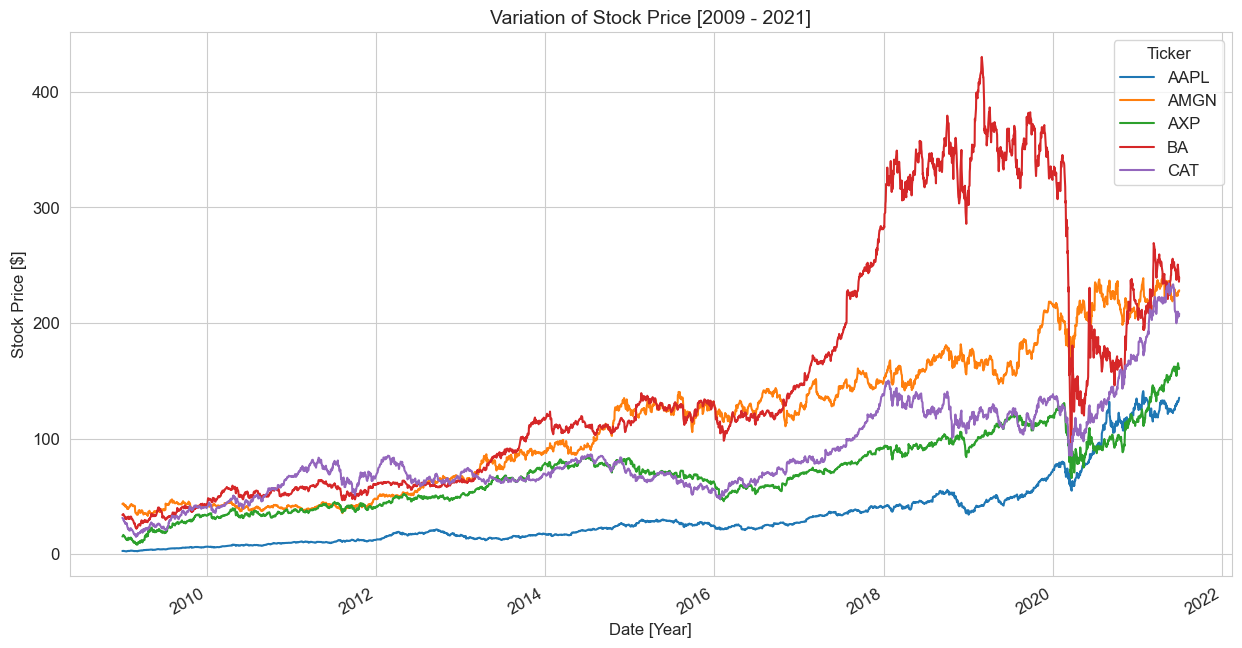

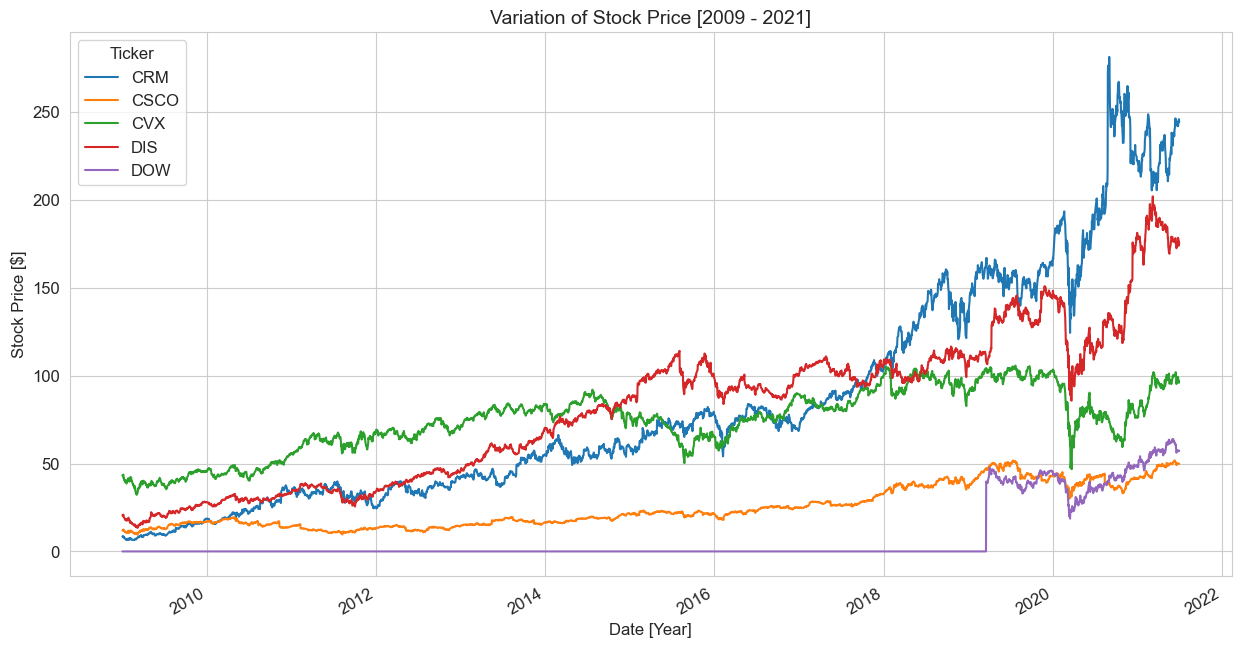

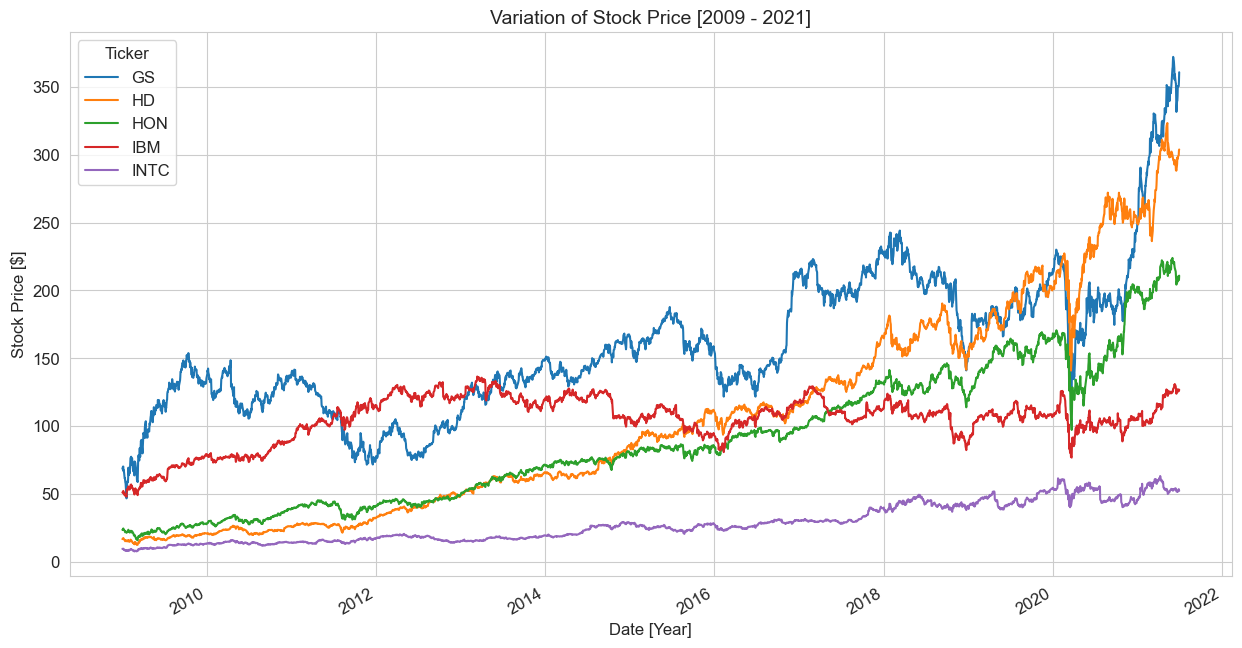

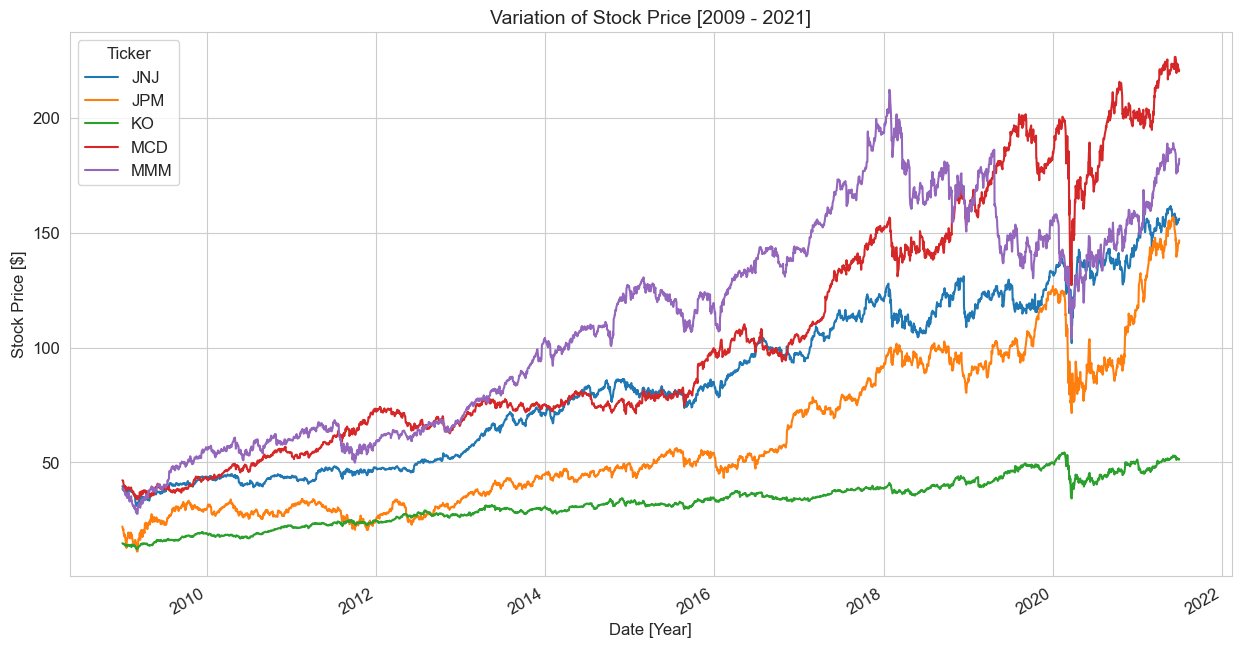

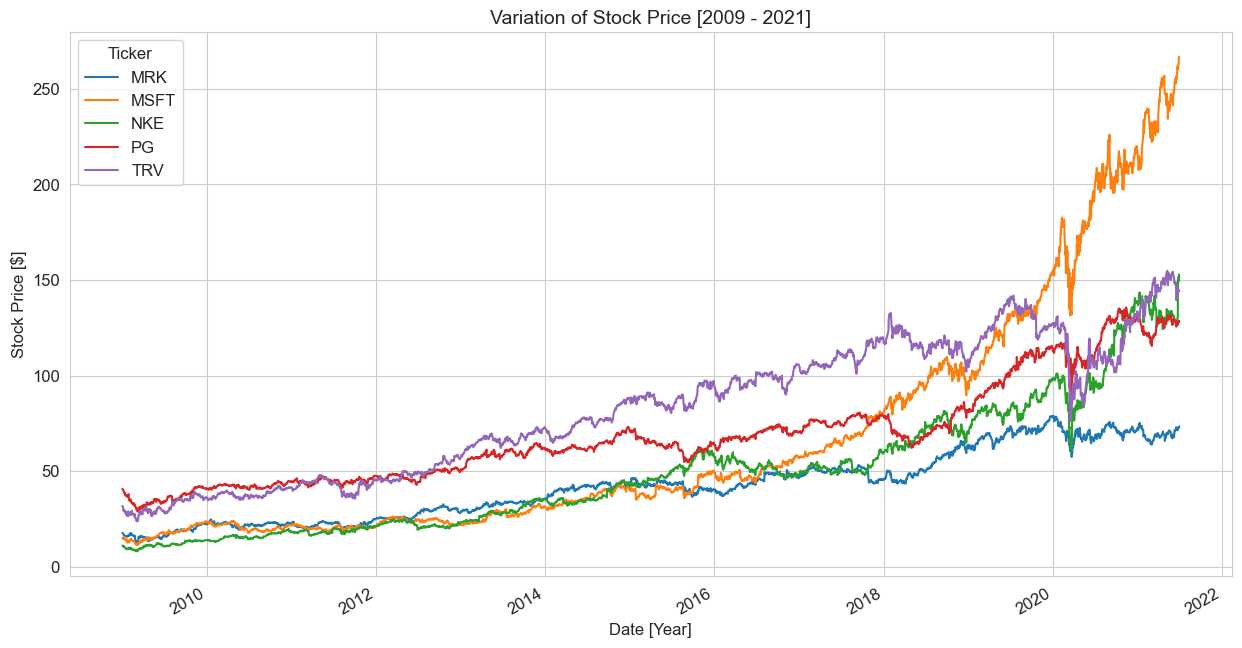

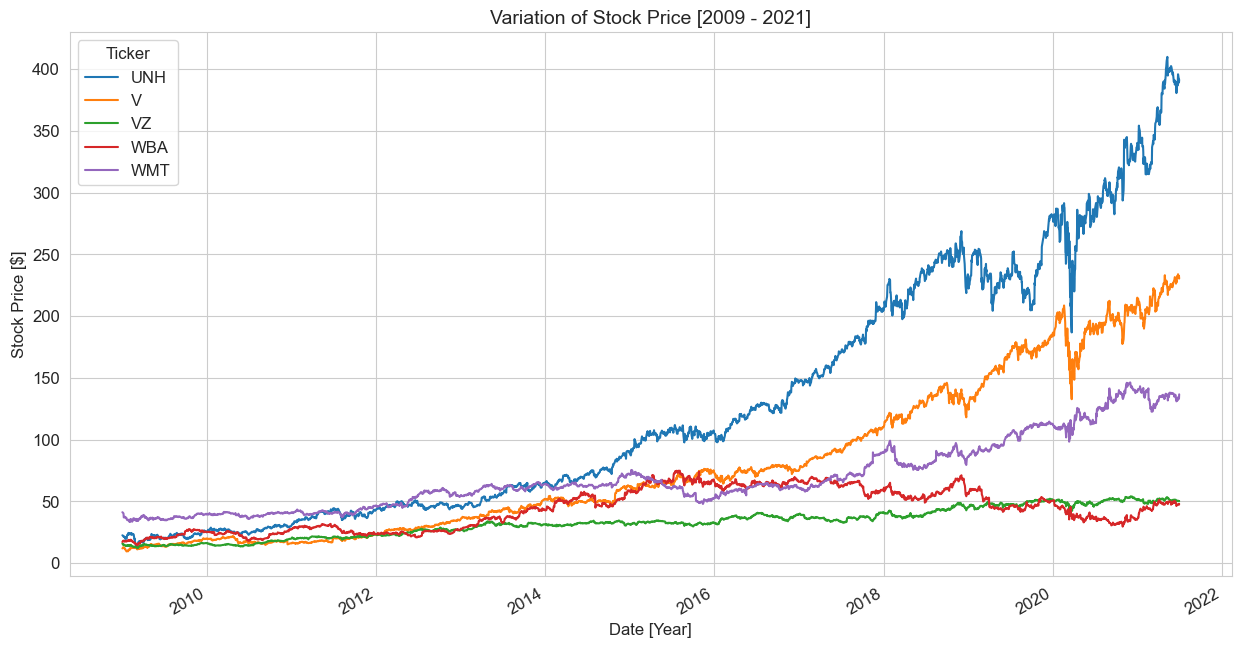

In [8]:
for i in range(5, 35, 5):
  df.iloc[:,(i-5):i].plot(kind='line', figsize=(15, 8),  fontsize=12)
  plt.xlabel('Date [Year]', fontsize=12)
  plt.ylabel('Stock Price [$]', fontsize=12)
  plt.legend(loc='best', fontsize=12,title='Ticker', title_fontsize='12')
  plt.title('Variation of Stock Price [2009 - 2021]', fontsize=14)
  plt.show()

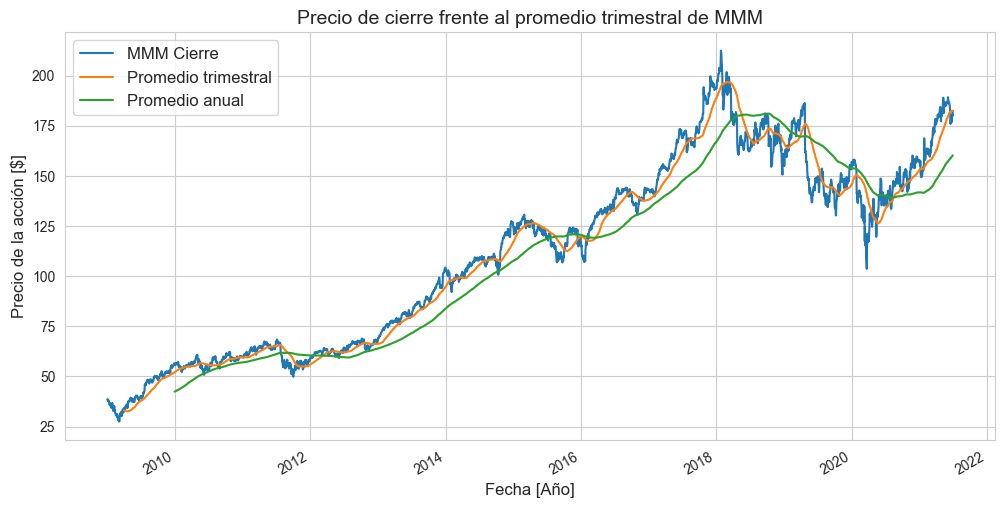

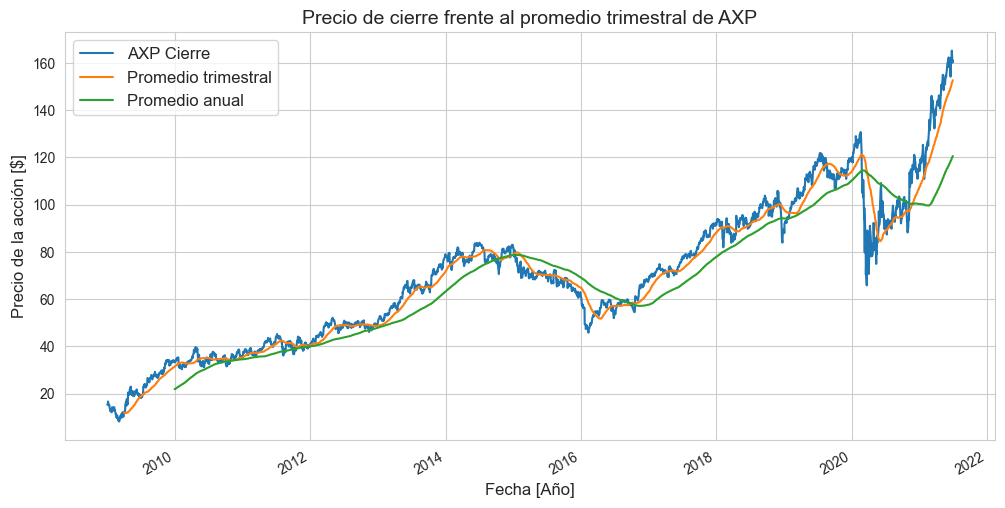

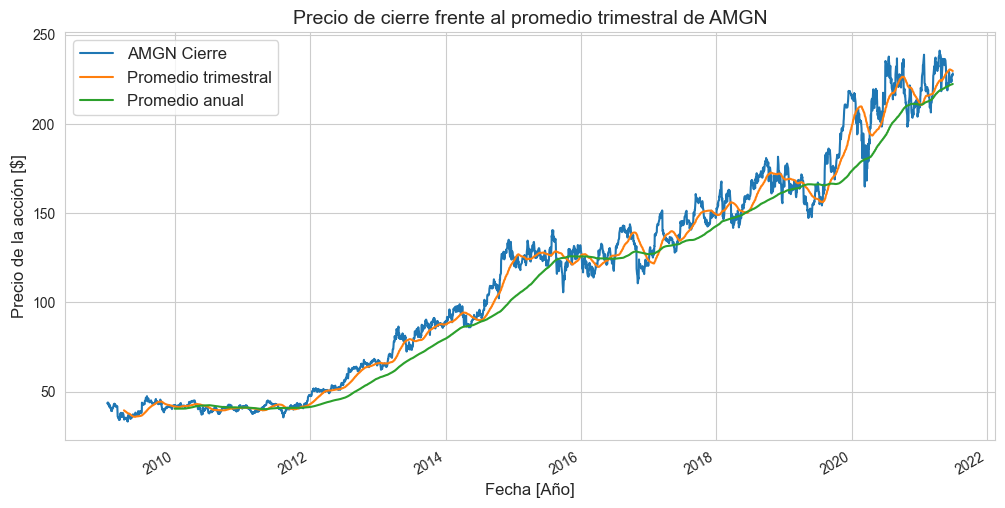

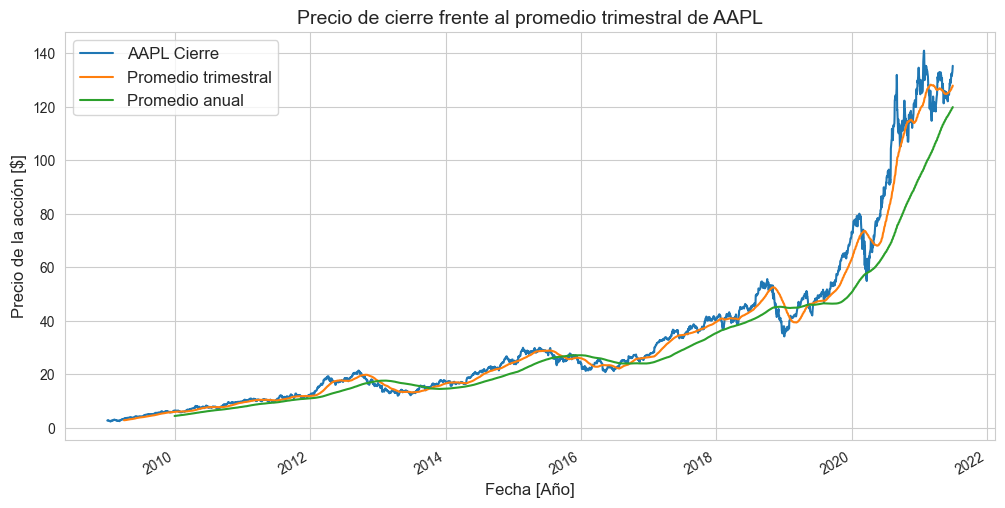

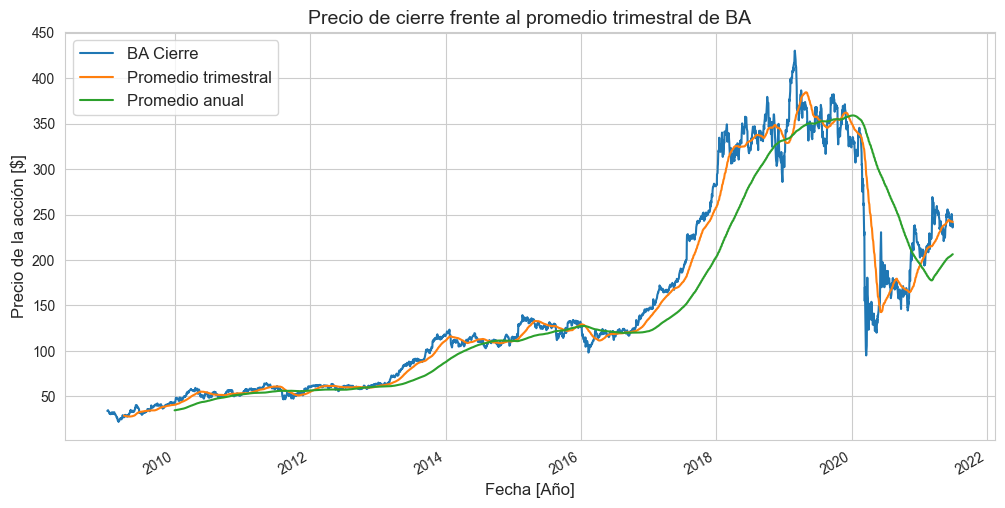

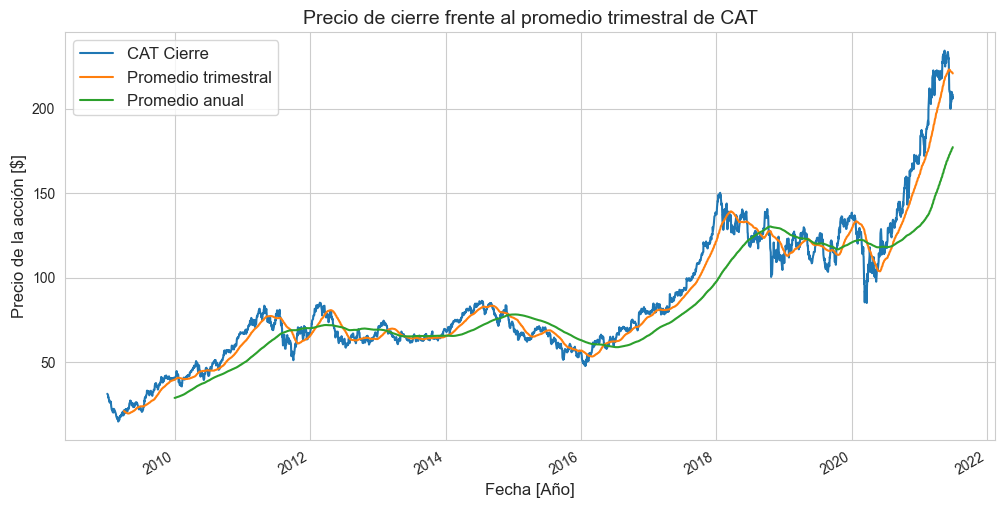

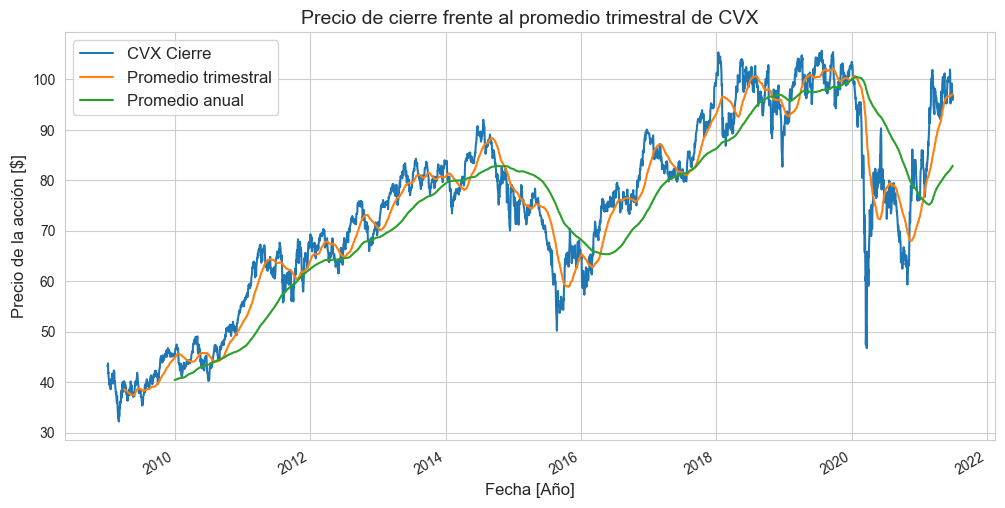

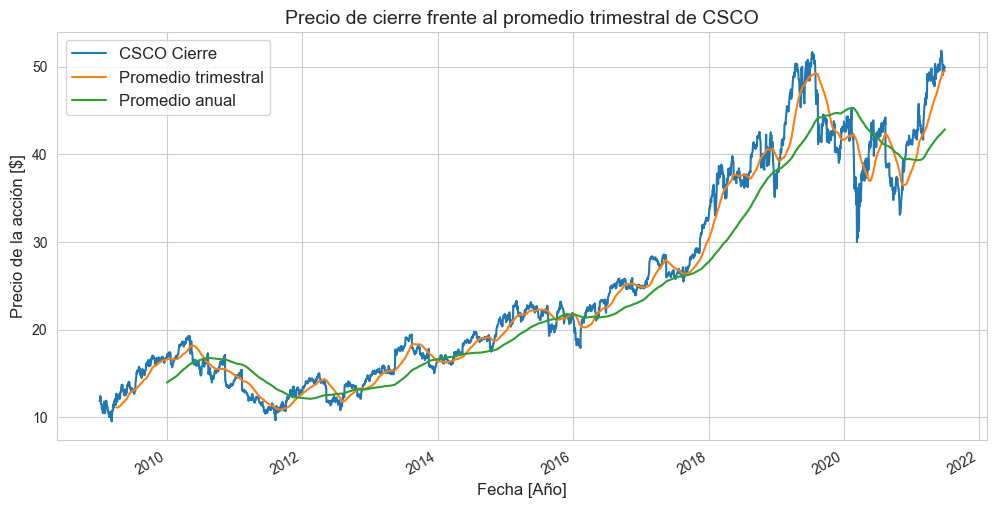

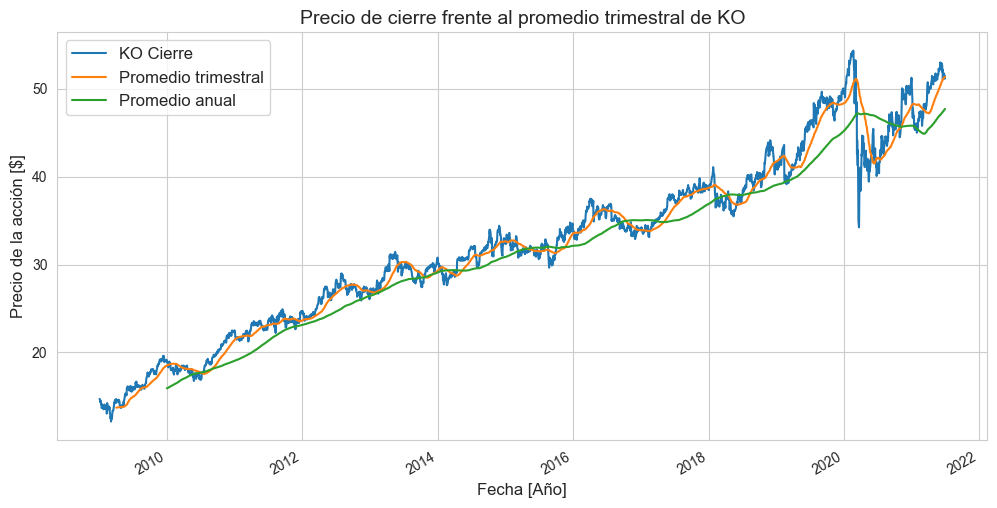

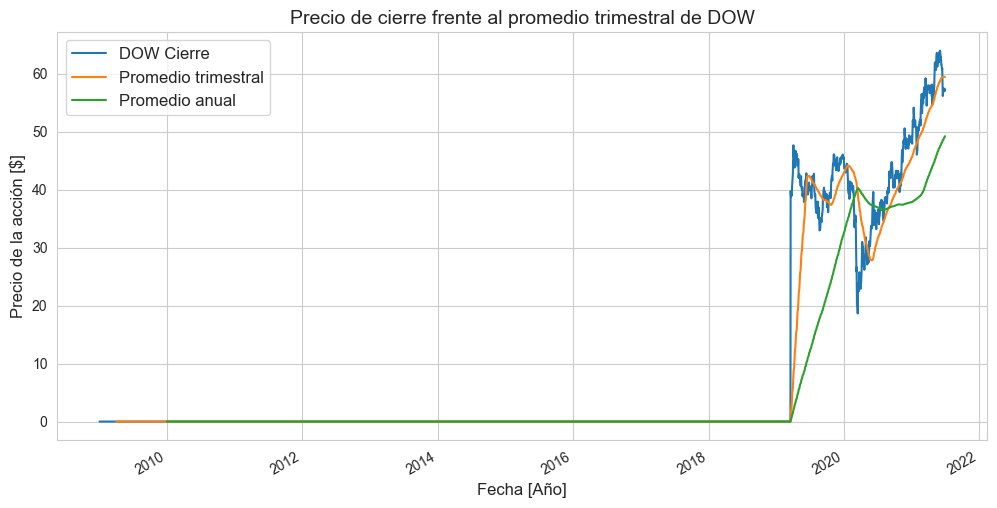

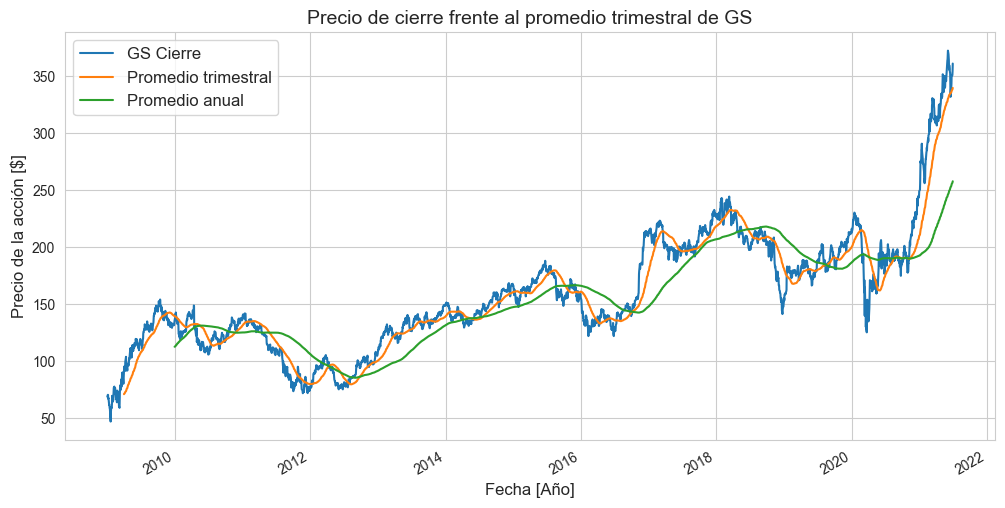

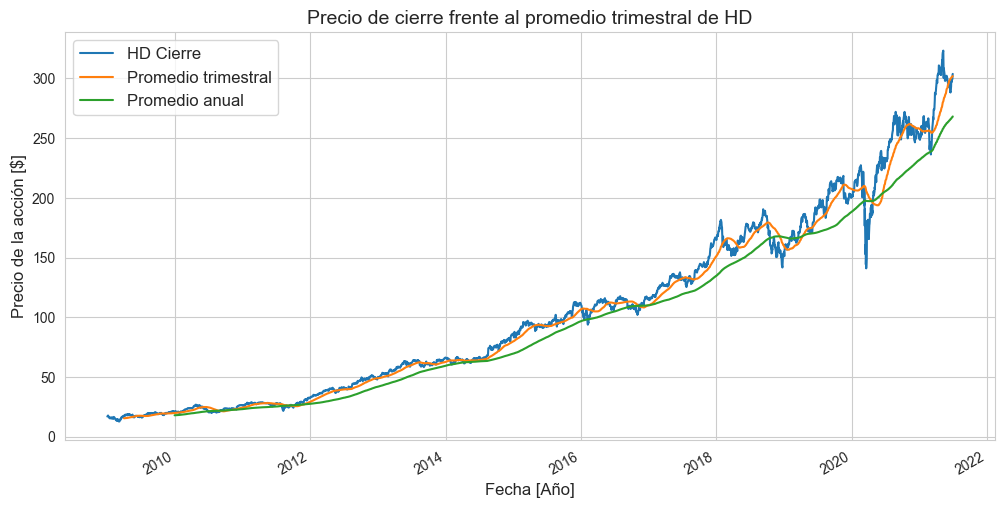

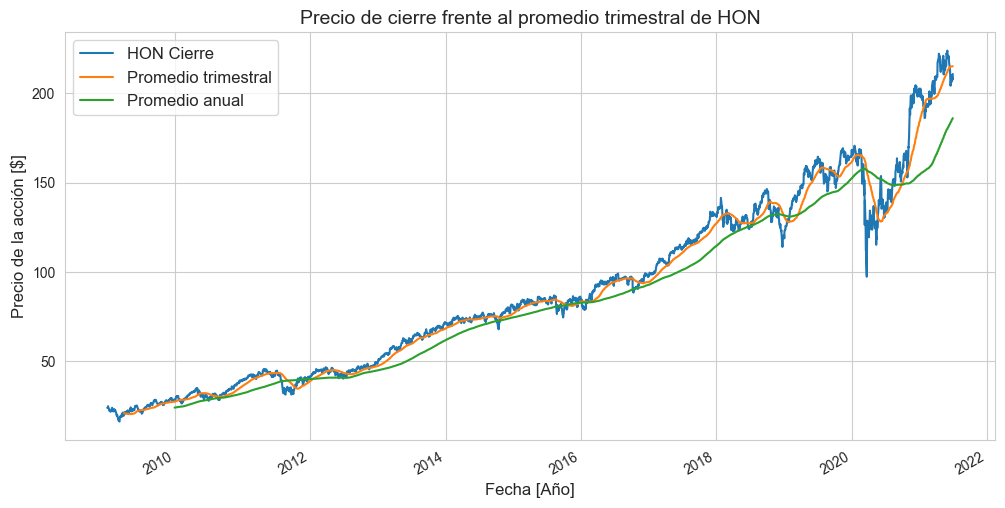

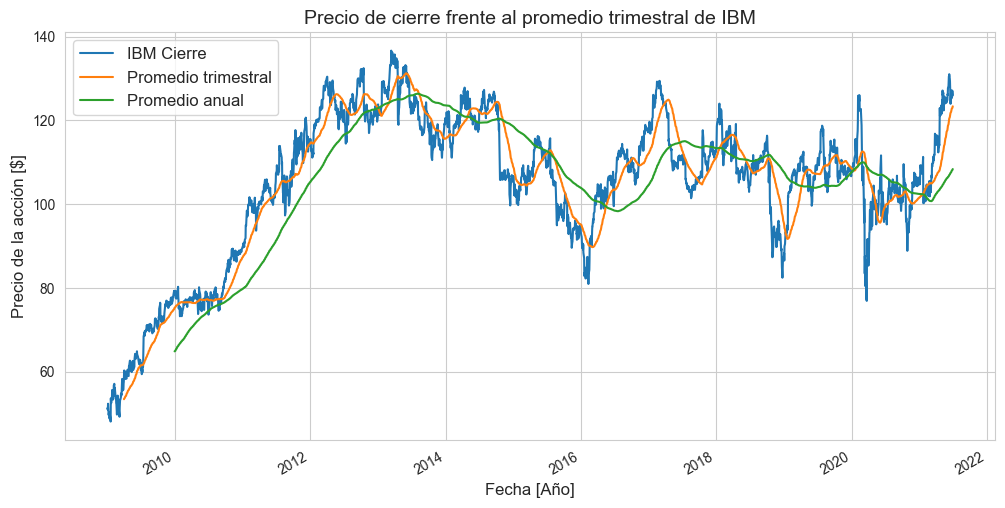

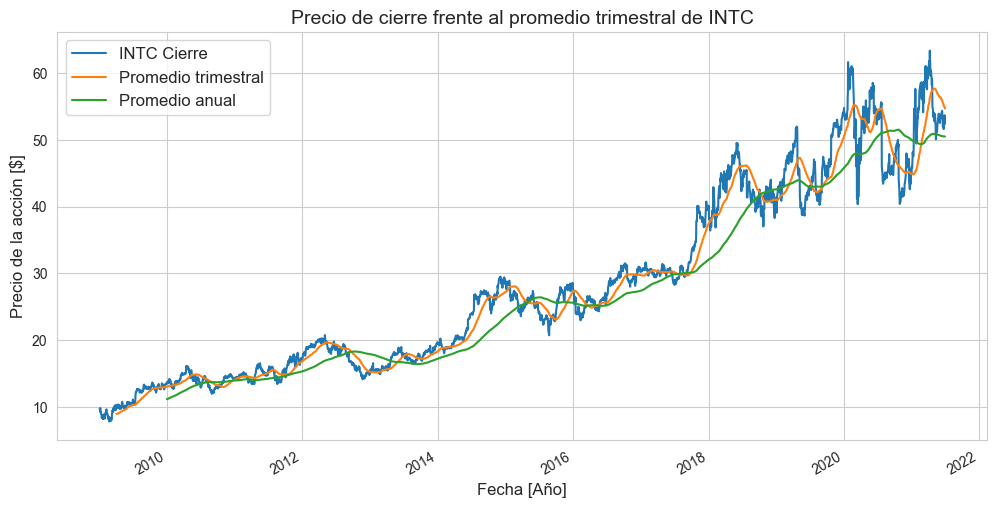

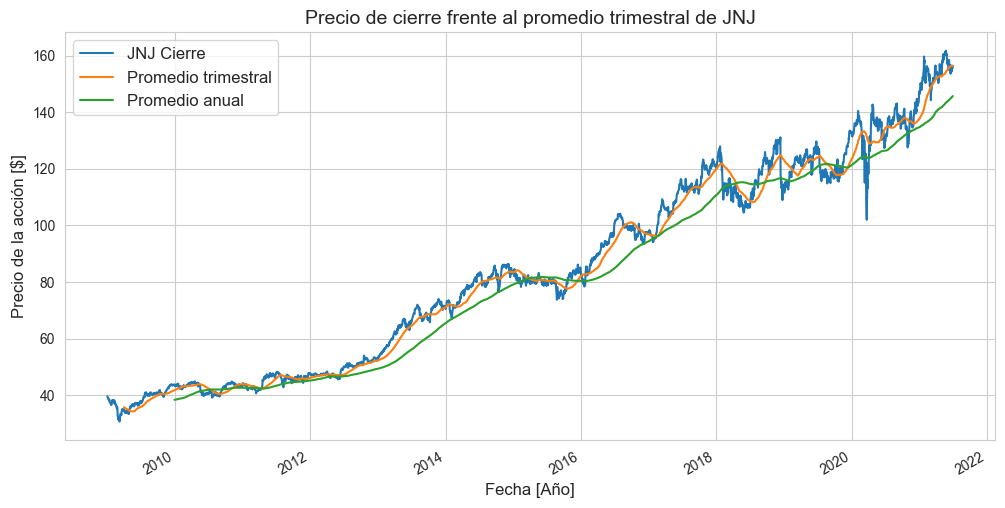

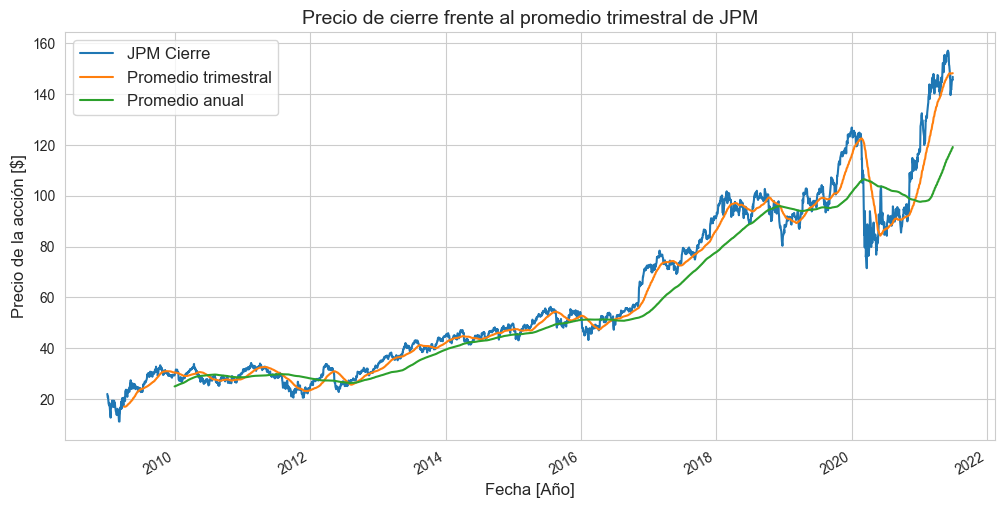

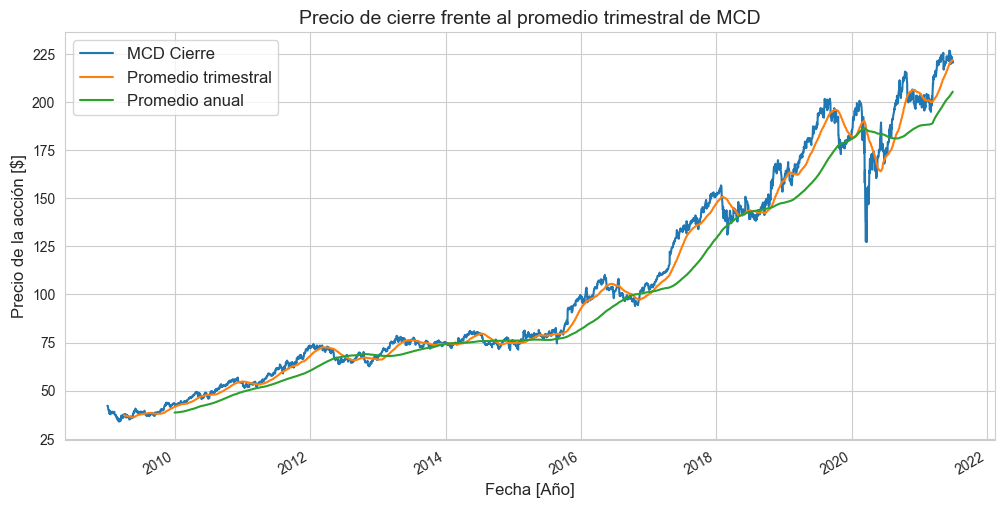

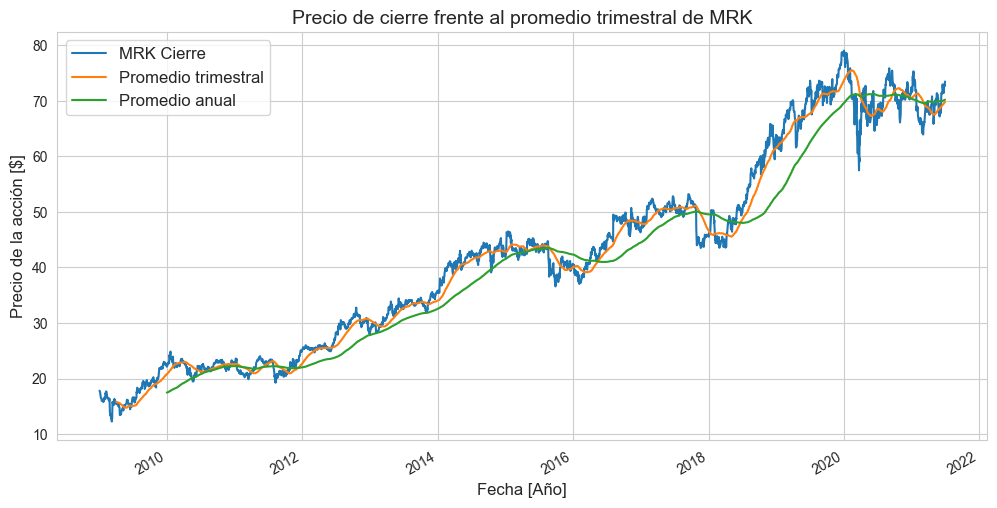

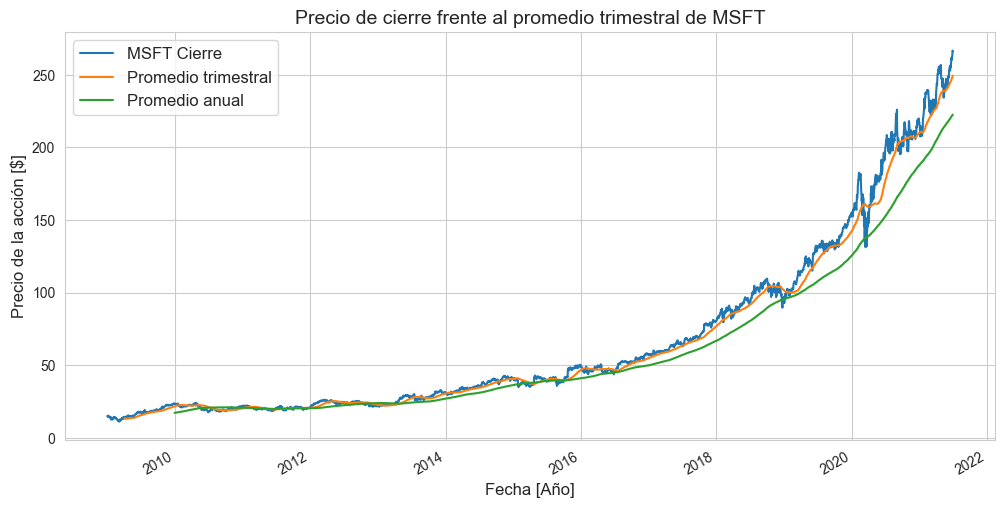

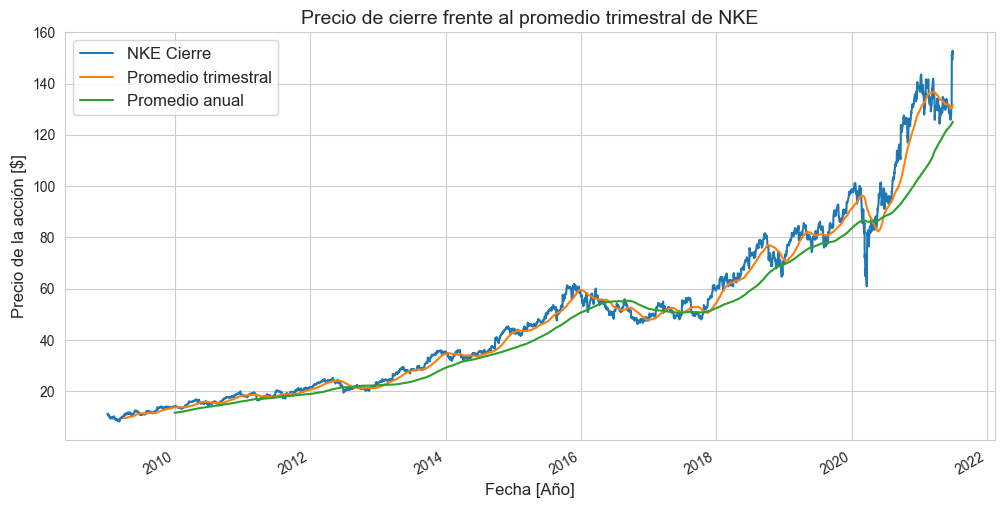

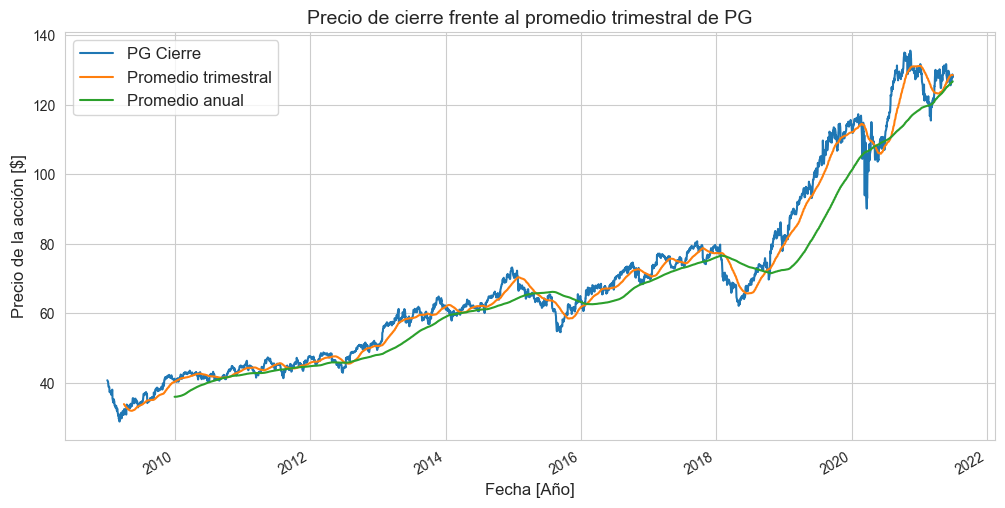

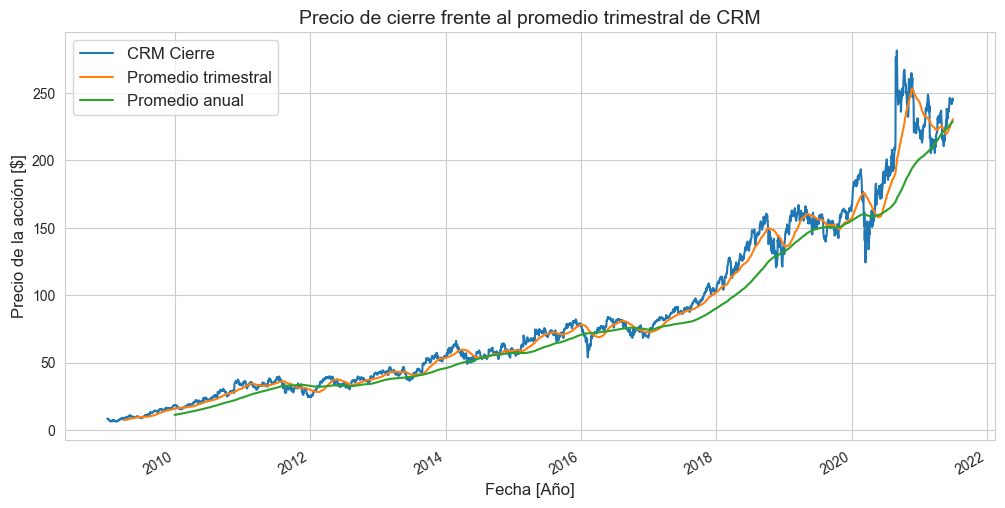

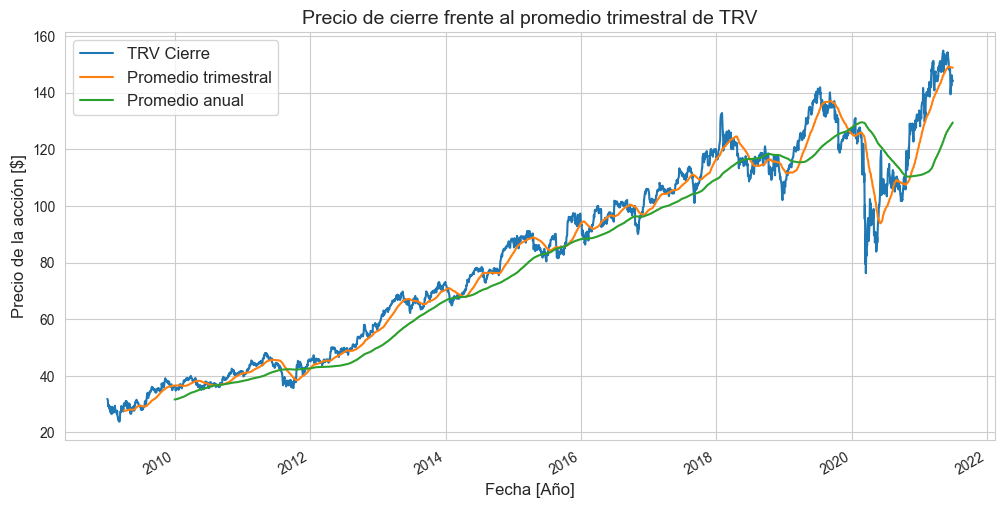

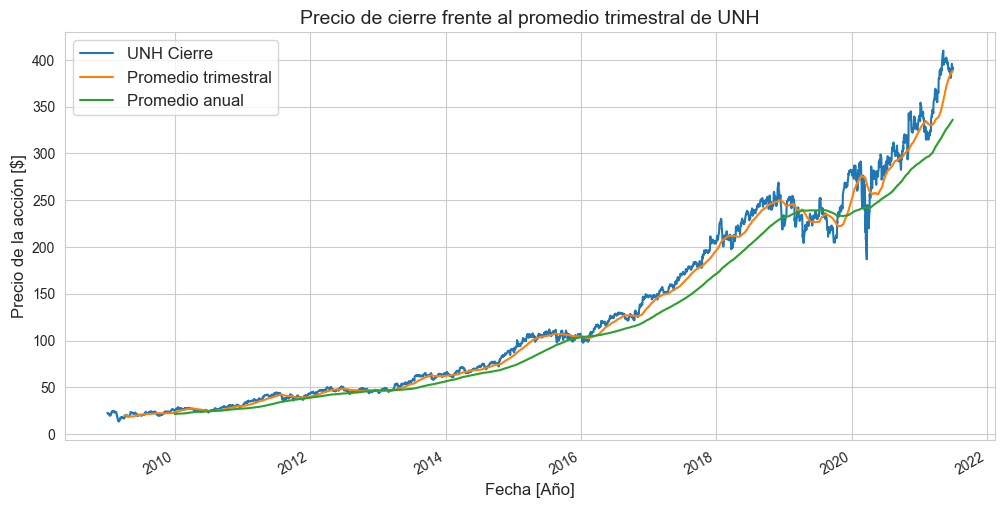

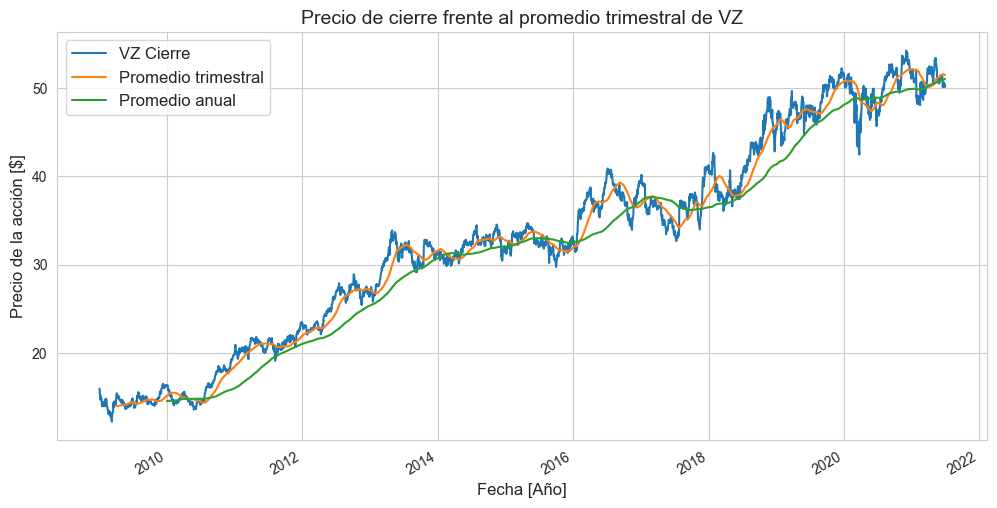

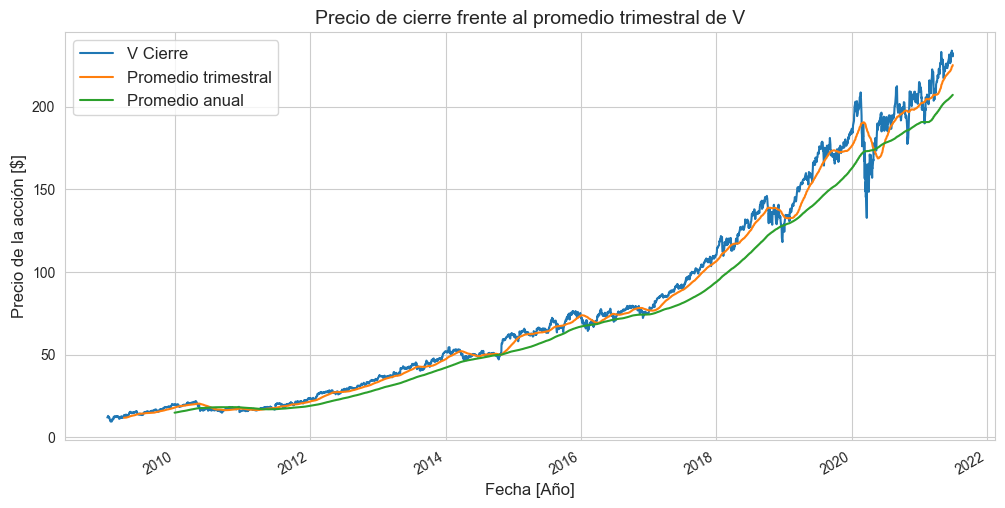

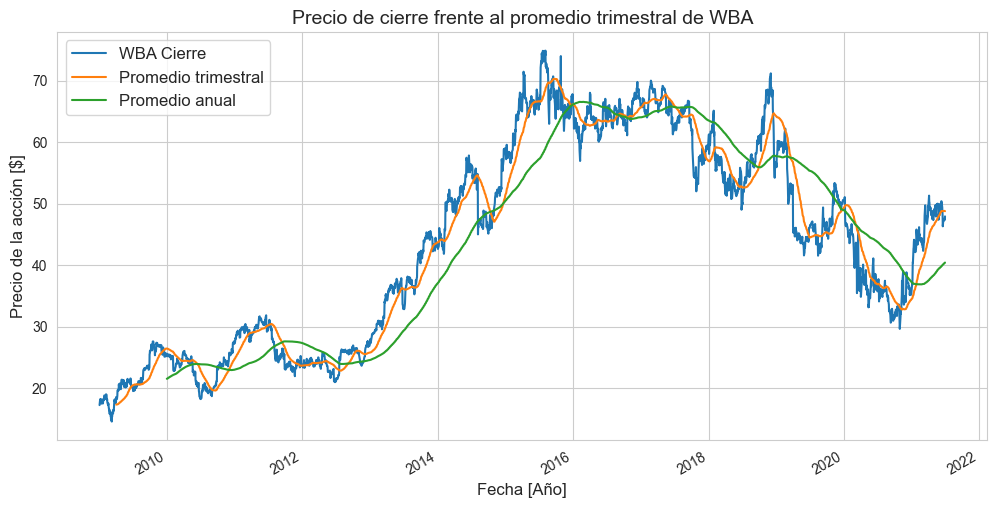

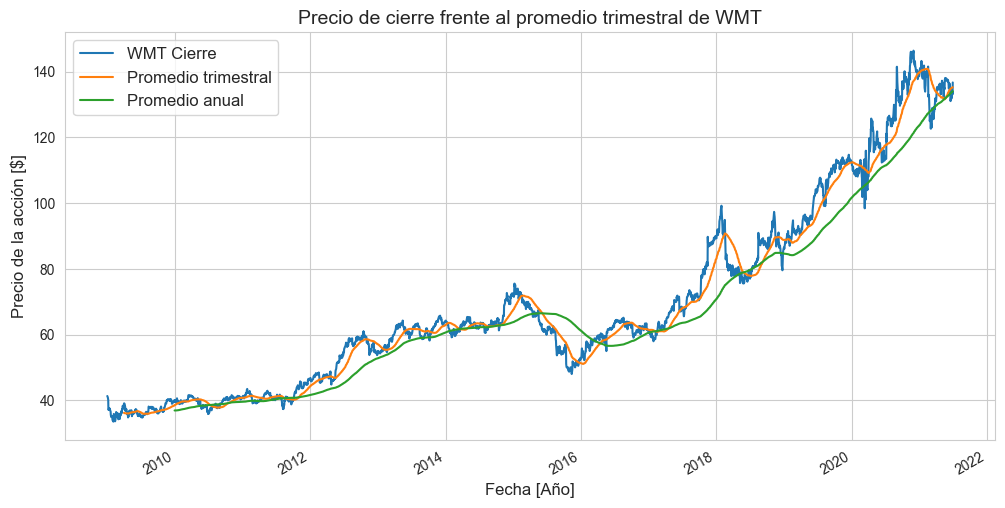

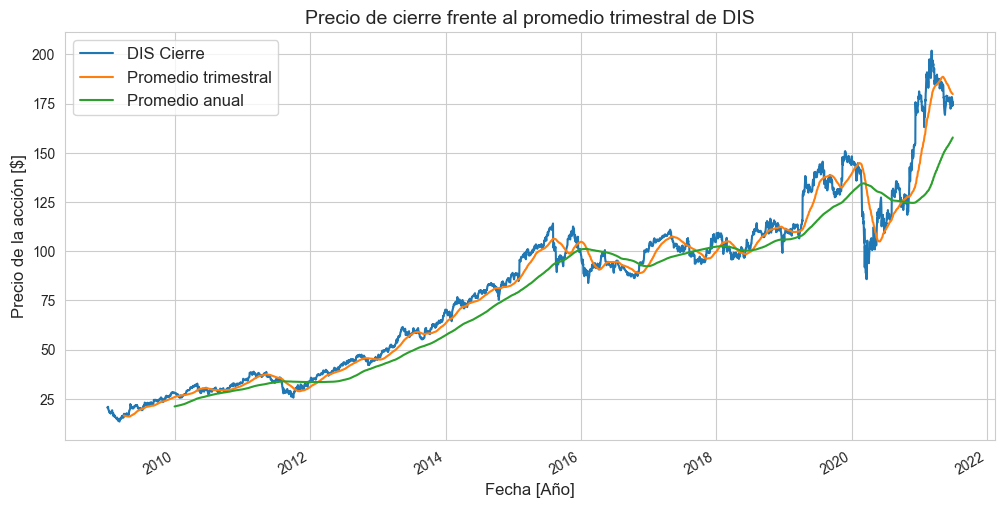

In [9]:
for idx in tic:
    plt.figure(figsize=(12, 6))
    df[idx].loc['2009-01-01':].plot(label = '{} Cierre'.format(idx))
    df[idx].loc['2009-01-01':].rolling(window=63).mean().plot(label='Promedio trimestral')
    df[idx].loc['2009-01-01':].rolling(window=252).mean().plot(label='Promedio anual')
    plt.xlabel('Fecha [Año]', fontsize = 12)
    plt.ylabel('Precio de la acción [$]', fontsize = 12)
    plt.legend(loc='best', fontsize = 12)
    plt.title('Precio de cierre frente al promedio trimestral de {}'.format(idx), fontsize = 14)
    plt.show()

<Axes: xlabel='Ticker', ylabel='Ticker'>

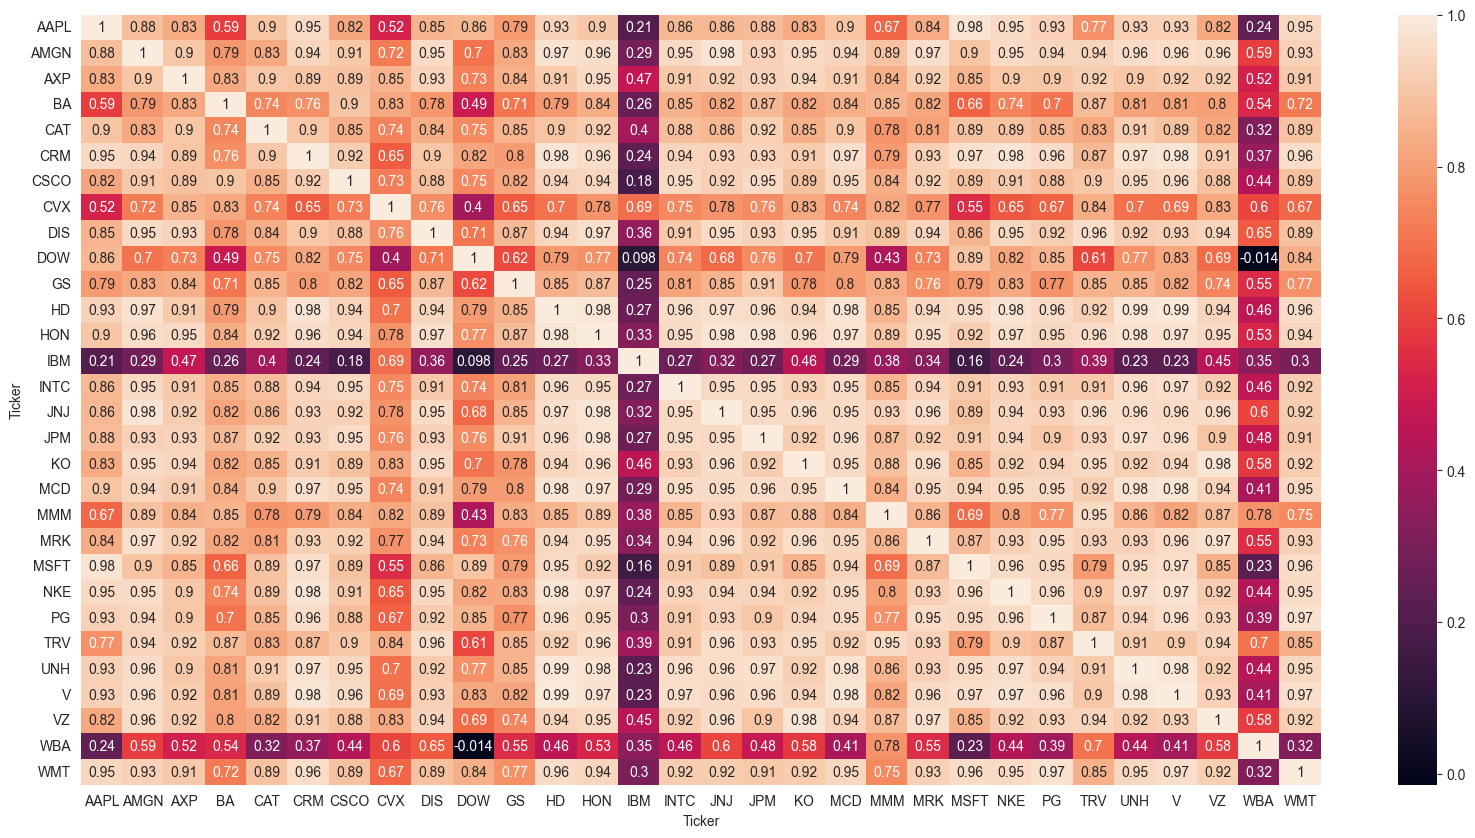

In [10]:
plt.figure(figsize=(20, 10)) 
sns.heatmap(df.corr(), annot=True)

## Preprocesamiento de datos

In [11]:
# Eliminación de la columna de precio de cierre 
stock_data=stock_data.drop('Close', axis=1) 

#Remanimg Adj Close 
stock_data=stock_data.rename(columns={'Adj Close': 'AdjClose'}) 

#Restableciendo el índice 
stock_data=stock_data.reset_index() 

#Ordenar los datos por fecha y teletipo y restablecer el índice 
stock_data=stock_data.sort_values(by=['Date', 'Ticker']).reset_index(drop=True)

In [12]:
# Ingeniería de características 
# Extracción de características de la columna de fecha
stock_data['Day'] = stock_data['Date'].dt.day_of_week 
stock_data['Week'] = stock_data['Date'].dt.weekday 
stock_data['Mes'] = stock_data['Date'].dt.month

In [13]:
uniq_date = stock_data.Date.unique() 
stocks = pd.DataFrame({'Date' : uniq_date}) 

stock_data_tech = pd.DataFrame() 

# Realice cambios primero calcule los indicadores técnicos y luego haga coincidir todas
# las acciones con fechas y luego rellene NaN con los últimos datos válidos observados 
for i in tic: 
  
    # Forzar a que todos los intervalos de fechas sean iguales para todas las acciones #DOW
    temp = pd.merge(stocks,
                    stock_data[stock_data.Ticker==i],
                    how='left',
                    on='Date' ) 
    
    # Rellenando los valores faltantes
    temp = temp.fillna(method='bfill' ) 
    
    print('Formato {} antes de fusionar: {} | después de fusionar: {}'.format(i, stock_data[stock_data.Ticker==i].shape, temp.shape)) 
    
    # Añadiendo todos los indicadores técnicos disponibles
    stock_tech = ta.add_all_ta_features(df=temp,
                                        open='Open',
                                        high='High',
                                        low='Low',
                                        close='AdjClose',
                                        volume='Volume',
                                        fillna=True ) 
    stock_data_tech = pd.concat([stock_data_tech, stock_tech])

Formato MMM antes de fusionar: (3145, 10) | después de fusionar: (3145, 10)
Formato AXP antes de fusionar: (3145, 10) | después de fusionar: (3145, 10)
Formato AMGN antes de fusionar: (3145, 10) | después de fusionar: (3145, 10)
Formato AAPL antes de fusionar: (3145, 10) | después de fusionar: (3145, 10)
Formato BA antes de fusionar: (3145, 10) | después de fusionar: (3145, 10)
Formato CAT antes de fusionar: (3145, 10) | después de fusionar: (3145, 10)
Formato CVX antes de fusionar: (3145, 10) | después de fusionar: (3145, 10)
Formato CSCO antes de fusionar: (3145, 10) | después de fusionar: (3145, 10)
Formato KO antes de fusionar: (3145, 10) | después de fusionar: (3145, 10)
Formato DOW antes de fusionar: (576, 10) | después de fusionar: (3145, 10)
Formato GS antes de fusionar: (3145, 10) | después de fusionar: (3145, 10)
Formato HD antes de fusionar: (3145, 10) | después de fusionar: (3145, 10)
Formato HON antes de fusionar: (3145, 10) | después de fusionar: (3145, 10)
Formato IBM an

In [14]:
stock_data_tech[['Date', 'Ticker', 'Open', 'High', 'Low', 'AdjClose', 'Volume', 'momentum_ppo', 'momentum_rsi', 'trend_adx', 'trend_macd', 'trend_cci']].sample(5)

Date Ticker        Open        High         Low    AdjClose   
2771 2020-01-07   AAPL   74.959999   75.224998   74.370003   72.869293  \
713  2011-10-31    JPM   35.930000   36.000000   34.730000   25.190224   
2167 2017-08-11    MMM  206.850006  206.850006  205.630005  167.355118   
1373 2014-06-18    TRV   95.190002   95.570000   94.910004   77.988098   
3100 2021-04-28    CRM  235.000000  238.330002  233.529999  236.880005   

           Volume  momentum_ppo  momentum_rsi  trend_adx  trend_macd   
2771  108872000.0      3.248215     75.981785  42.622889    2.239054  \
713    46429800.0      2.578620     55.084129  16.522487    0.622443   
2167    1452800.0     -0.240950     48.083624  20.484091   -0.404294   
1373    2556600.0      1.390087     74.088412  48.032550    1.061423   
3100    4274500.0      1.913940     64.802743  27.016863    4.347825   

       trend_cci  
2771  118.890690  
713   108.501434  
2167    0.181216  
1373   91.098519  
3100  109.094379

In [32]:
class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, Shares_Per_Trade = 10, Initial_Investment = 10000, Action_Space = 30, Observation_Space = 211, day = 0, 
                 Normalized_Rewards = 1e-4, verbosity = 0, mode = 'train', seed = 10, commission = 0 ):
      
      self.day = day
      self.df = df
      self.max_shares_per_trade = Shares_Per_Trade
      self.initial_investment = Initial_Investment
      self.Action_Space = Action_Space
      self.Observation_Space = Observation_Space
      self.normalized_rewards = Normalized_Rewards
      self.verbosity = verbosity
      self.commission = commission
      #self.model = model
      self.mode = mode
      self._seed(seed)


      #Action Space
      # Action > 0  means buy shares of stock
      # Action 0 means Hold the stock
      # Action < 0 means sell shares of stock
      self.action_space = spaces.Box(low=-1, high=1, 
                                     shape=(self.Action_Space,), dtype= np.int)

      #Observation Space
      self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.Observation_Space,))

      #Selecting the Data for one date
      self.data = self.df.loc[self.day,:]

      #Initial Run
      self.initial = True

      #Verify if tradings days are completed or not
      self.done = False

      #Rewards
      self.reward = 0

      #Asset value after each trading day
      self.asset_memory = [self.initial_investment]

      #Rewards received for each trading day i.e profit or loss
      self.reward_memory = []

      #Saving the date for the trade
      self.date_memory = [self.data.Date.unique()[0]]

      #Initializing state of the environment

      self.state = [self.initial_investment] + self.data.AdjClose.values.tolist() + [0]*self.Action_Space + \
        self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
        self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
        self.data.trend_cci.values.tolist()

    
    def render(self, mode='human'):
      return self.state
    
    # This method is used to reset the values of the state to it's default after every episode
    def reset(self):
      
      self.day = 0
      self.reward = 0
      self.data = self.df.loc[self.day,:]
      self.done = False
      self.initial = False
      self.reward_memory = []
      self.date_memory = [self.data.Date.unique()[0]]
      self.asset_memory = [self.initial_investment]
      self.state = [self.initial_investment] + self.data.AdjClose.values.tolist() + [0]*self.Action_Space + \
        self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
        self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
        self.data.trend_cci.values.tolist()
      #print(self.state)
      return self.state
    
    def step(self, actions):
      self.done = self.day >= len(self.df.Date.unique())-1

      #Use this to save the results to csv after we performed trading for all the days
      if self.done:
        
        final_portfolio_value = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))
        
        total_rewards = final_portfolio_value - self.initial_investment
        profit_pct = (total_rewards*100)/self.initial_investment

        asset_df = pd.DataFrame(self.asset_memory)
        asset_df.columns = ['portfolio']
        asset_df['date'] = self.date_memory

        if self.verbosity and self.mode != 'train':

          #print(len(self.reward_memory))
          #if self.mode == 'trade' or self.mode == 'val':
          print( 'Initial Portfolio Value : {} | Final Portfolio Value : {} | Total rewards : {} | % of profit : {}'.format(self.initial_investment, final_portfolio_value,total_rewards, profit_pct))
          asset_df.to_csv('{}_{}_results'.format(self.mode, self.commission))
        return self.state, self.reward, self.done, {}
      
      else:

        #Calculating the portfolio value before start of trading 
        #Available investment amount + sum of value of each stock held (no.of shares per stock * price of the stock on that day)
        portfolio_before_trade = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))

        #Extracting the indicies of sell action
        #if actions is not an array then convert it to array using np.array()
        sell_indices = np.where(actions <  0 )[0]

        #Extracting the indicies of buy action
        buy_indices = np.where(actions >  0 )[0]

        ###### Trading starts #######
        # Initially selling the stocks to increase investment value
        for idx in sell_indices:
          #Sell stock if price is > 0 and shares held > 0

          if self.state[idx+1] > 0 and self.state[idx+self.Action_Space+1] > 0:
            
            #No of shares to sell
            shares_sell = min(self.state[idx+self.Action_Space+1], abs(actions[idx]*self.max_shares_per_trade))

            #Updating the available cash after selling the stocks
            self.state[0] += self.state[idx+1]*shares_sell*(1-self.commission)
            
            #Updating the available stocks after selling
            self.state[idx+self.Action_Space+1] -= shares_sell

          else:
            # print('No Shares to sell')
            pass

        #print('Buying Stock shares : ')
        for idx in buy_indices:
          #Buy stocks if price is > 0

          if self.state[idx+1] > 0 and self.state[0] > 0:
            
            #Max number of shares that can be brought with the available cash (available cash / stock price)
            max_shares_buy = self.state[0]*(1 - self.commission)//self.state[idx+1]

            #No of shares to buy
            shares_buy = min(max_shares_buy, actions[idx]*self.max_shares_per_trade)

            #Updating the available cash after selling the stocks
            self.state[0] -= self.state[idx+1]*shares_buy*(1 + self.commission)
            
            #Updating the available stocks after selling
            self.state[idx+self.Action_Space+1] += shares_buy
          
          else:
            # print('No Shares purchased')
            pass

        ###### Trading ends #######
        # print('*************** Trading Ends ***************')
        # print('Available cash for after trading : {}'.format(self.state[0]))
        # print('Shares available per stock : '.format(np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1])))
        # print('Over all portfolie before Trading : {}'.format(portfolio_after_trade))
        # print('Profit or Loss for Day {} : {} is {}'.format(self.day, self.date_memory[-1], self.reward))
        
        #Setting the values for next trading date
        self.day += 1
        self.data = self.df.loc[self.day,:]
        
        self.state = [self.state[0]] + self.data.AdjClose.values.tolist() + list(self.state[(self.Action_Space+1):(2*self.Action_Space)+1]) + \
                      self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
                      self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
                      self.data.trend_cci.values.tolist()
        
        
        portfolio_after_trade = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))
        #Total trade in a day (profit or loss)
        self.reward = portfolio_after_trade - portfolio_before_trade
        #print('Day : {} | Reward : {}'.format(self.day-1, self.reward))
        self.reward_memory.append(self.reward)
        self.asset_memory.append(portfolio_after_trade)
        self.date_memory.append(self.data.Date.unique()[0])

        self.reward = self.reward*self.normalized_rewards     #Normalizing the reward

        return self.state, self.reward, self.done, {}


    def _seed(self, seed=10):
      randomState, seed = seeding.np_random(seed)
      return [seed]

## Simulación del modelo de aprendizaje por refuerzo

In [16]:
def render_trading(model, env, data, n_episodes = 1):
  episode_rewards = [0.0]
  obs = env.reset()
  env.render()

  for i in range(n_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs)
        #print(action)
        obs, rewards, done, info = env.step(action)
        env.render()

        # Stats
        if done:
          obs = train_env.reset()
          #print('Episode {} Rewards {}'.format(i+1, episode_rewards[-1]))
          episode_rewards.append(0.0)
        else:
          #print(rewards)
          episode_rewards[-1] += rewards

    if (i+1)%10 == 0 and i != 0:
      print('Average reward {}'.format(np.average(episode_rewards[:i+1])))
  
  return episode_rewards

## Dividir el conjunto de datos en tren, validación y datos comerciales

In [17]:
stock_df = stock_data_tech.copy()

#Training Data - 2009 --> 2015
train_data = stock_df[(stock_df.Date >= '2009-01-01') & (stock_df.Date < '2016-01-01')].sort_values(by=['Date', 'Ticker'])

#Validation Data - 2016
validation_data = stock_df[(stock_df.Date >= '2016-01-01') & (stock_df.Date < '2017-01-01')]
validation_data.sort_values(["Date", "Ticker"], ignore_index=True)
validation_data.index = validation_data.Date.factorize()[0]

#Trading Data - 2017 --> 2021
trading_data = stock_df[(stock_df.Date >= '2017-01-01')]
trading_data.sort_values(["Date", "Ticker"], ignore_index=True)
trading_data.index = trading_data.Date.factorize()[0]

## Configuración de entornos comerciales reales, de validación y de capacitación

In [18]:
# Environment Parameters
Shares_Per_Trade = 5                        # Maximum shares that can be purchased or sold in a trade
Initial_Investment = 10000                  # Initial Investment
Action_Space = 30                           # Number of stocks
Observation_Space = 1 + 30 + 30 + 30*5      # Initial Investment + Stocks Closing Prices + Shares holding per stock + stocks * Technical Indicators
Normalized_Rewards = 1e-2                   # Factor used to normalized the rewards
commission = 0                              # Commission for trading

In [31]:
#Entorno de formación 
tren_env = DummyVecEnv([lambda: StockTradingEnv(train_data, Shares_Per_Trade, 
                                                Initial_Investment, Action_Space, 
                                                Observation_Space, verbosity=0, 
                                                Normalized_Rewards=Normalized_Rewards, 
                                                commission=commission)]) 
tren_env = VecNormalize(train_env, norm_reward=False )

TypeError: cannot unpack non-iterable NoneType object